Adam Peetz<br>
October 9th 2022<br>
MSDS680 Week 7 Assignment<br>
Regis University<br>
Professor Nasheb Ismaily<br>

# Improving Cold Call Efficiency with Data

No one enjoys receiving cold calls for products and services they have no desire for. On the occasion someone does need a product, they are happy engage with a sales person who can offer them a service to fill their needs. This fact of life makes improving the efficiency of cold call campaigns a win for both the customers who receive them and the companies that pay for it.

In 2014, Moro et al. ran a machine learning experiment that tested the efficiency of 4 algorithms on the prediction of a successful cold call. This experiment was driven by a dataset from a telephone marketing campaign paid for by a Portuguese bank. Between their 4 models, Moro et al. achieved a maximum AUC score of around 80%. The goal of this notebook is to beat the AUC score of Moro et al. with a similar group of models by employing a blend of techniques including feature reduction, under sampling, and hyperparameter tuning.


In [1]:
#load required libraries:
# pandas
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
from numpy import sqrt
from numpy import argmax
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, roc_curve, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import auc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set() 

In [2]:
#create df from csv
bank_df = pd.read_csv('bank-additional-full.csv',delimiter=';')

# Data Preparation

The bank dataset contains 22 features. These features are a mix of categorical and numeric features of varying scale. There is an imbalance in the target variable y, 88.7% of the samples are class 0, and 11.3% of the samples are class 1. To prepare this data for machine learning, all the categorical features will be converted to numeric labels using sci-kit learn's label encoder. After features have been encoded, the dataset will be scaled using sci-kit learn's minmax scaler to reduce all the features to a common scale. These operations are shown in the cells below.


In [3]:
#sample bank df
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<Figure size 432x288 with 0 Axes>

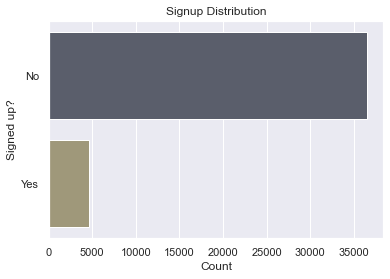

<Figure size 432x288 with 0 Axes>

In [4]:
#group and count, sort for highest value
graph = bank_df.groupby('y').count()
graph['y'] = ['No', 'Yes']
graph.sort_values(by='age',inplace=True,ascending=False)
sns.barplot(data=graph,x='age',y='y',palette='cividis')
plt.ylabel('Signed up?')
plt.xlabel('Count')
plt.title('Signup Distribution')

plt.figure()

In [5]:
# display lass balance by percentage
bank_df.groupby('y')['age'].count().sort_values(ascending=False).head(10)/bank_df.shape[0]

y
no     0.887346
yes    0.112654
Name: age, dtype: float64

In [6]:
#create label encoder object
labelencoder= LabelEncoder()

#define column names for encoding
encoder_names = ['job','marital','education','default','housing','loan','contact', \
               'month', 'poutcome','day_of_week','y']

#apply encoding to dataframe
for col in encoder_names:
    bank_df[col] = labelencoder.fit_transform(bank_df[col])

In [7]:
#define scaler objext
scaler = MinMaxScaler()

#define column names for scaling
scaler_names = ['age','job','marital','education','default','housing','loan','contact','month', \
               'day_of_week', 'duration', 'campaign','pdays', 'previous','poutcome','emp.var.rate' ,\
               'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

#apply scaling to dataframe
for col in scaler_names:
    bank_df[col] = scaler.fit_transform(bank_df[col].values.reshape(-1,1))

# Dropping Low Correlation Features

Moro et al. (2014) started with 150 features and trimmed that feature set down to 22 using business knowledge and a feed forward analysis. Plotting feature correlation shows that many features left in the dataset by Moro et al. have low correlation to the target variable. An additional 15 features with correlation of less than 10% will be removed to further reduce the dataset. Tests ran against the original feature set and the reduced feature set showed that this reduction slightly increased the prediction performance of models for the target variable "y".

## Null Values

Null values were filled with "unknown" by Moro et al. (2014) during the preparation of the dataset. Columns that contain "unknown" are jobs, marital status, education, default, housing, and loan. These features are all dropped due to low correlation with the target variable.


<AxesSubplot:>

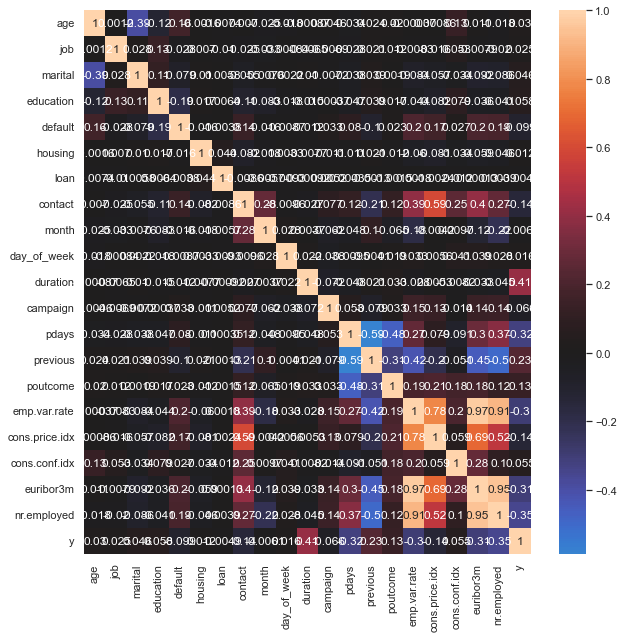

In [8]:
#define figure size
f = plt.figure(figsize=(10, 10))
#generate feature correlation plot
sns.heatmap(bank_df.corr(),center=0,annot=True)

In [9]:
#drop low correlation columns

#create list of columns to drop
drop_cols = ['age','job','marital','education','default','housing','loan','month','day_of_week',\
            'campaign','cons.conf.idx']

#drop non-functional columns
bank_df.drop(drop_cols,axis=1,inplace=True)

<AxesSubplot:>

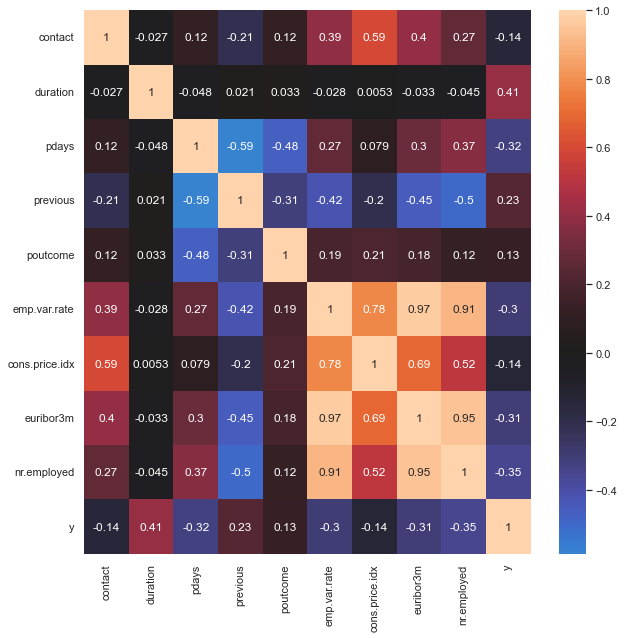

In [10]:
#define figure size
f = plt.figure(figsize=(10, 10))
#generate feature correlation plot
sns.heatmap(bank_df.corr(),center=0,annot=True)


# Visualization with PCA

The spread of features can be visualized using PCA. PCA reduces multiple features down into 2 dimensions that capture the maximum amount of variation in the dataset. The scatterplot created by PCA can be colored with the ground truth labels to show how these features form clusters. There are 4 clusters that have formed in the reduced Moro et al. dataset. While all 4 clusters have mixed labels, a few areas show a preference for one label over the other.


Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

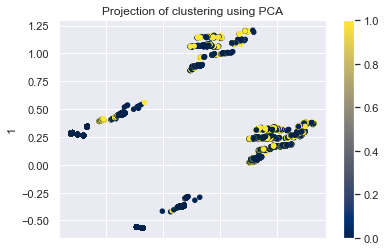

In [11]:
#create PCA object
pca = PCA()
#divide into features and targets
features = bank_df.drop('y', axis=1)
targets = bank_df['y']
#reduce dimensonality of the features
data_reduced = pca.fit_transform(features)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=targets, cmap='cividis')
plt.title('Projection of clustering using PCA')

# Under sampling the Majority Class

These models were run twice, first with a regular train test split and then with under sampling at a ratio of 2 major to 1 minor sample. With unmodified data, algorithms were unlikely to predict for the minority class. Adding under sampling caused the models to improve their predictions for the minority class "y". This change resulted in a greater than 10% increase in model AUC scores at a reduction of less than 3% overall accuracy. Based on the strength of these results, under sampling will be included on the dataset and used in the models that follow.



In [12]:
#Undersampling the majority class

#https://www.kaggle.com/code/jdelamorena/recall-97-by-using-undersampling-neural-network/notebook
#https://www.geeksforgeeks.org/divide-a-pandas-dataframe-randomly-in-a-given-ratio/

# Creating a dataframe with 80% of values of original dataframe
undersample_df = bank_df.sample(frac = 0.8,random_state=125)
 
# Creating dataframe with the remaining 20% of values
holdoutset_df = bank_df.drop(undersample_df.index)

# create integer value for number of fraud cases
number_records_y = len (undersample_df[undersample_df.y==1]) * 2

# obtain index positions of fraud and legitimate rows 
y_indices = np.array (undersample_df[undersample_df.y==1].index)
n_indices = np.array (undersample_df[undersample_df.y==0].index)

# randomly select non-fraudulent index positions equal to number of fraud cases
np.random.seed(2020)
random_n_indices = np.random.choice (n_indices, number_records_y, replace = False)

# concatenate fraudulent and legitimate index numbers for use assembling a new index count
under_sample_indices = np.concatenate ([y_indices, random_n_indices])

# generate new dataframe with undersampled indexes
under_sample_df = bank_df.iloc[under_sample_indices,:]

# create new test split with undersampling
X_undersample = under_sample_df.iloc [:, under_sample_df.columns != 'y'];
y_undersample = under_sample_df.iloc [:, under_sample_df.columns == 'y'];

#create holdout set features and targets
X_holdout = holdoutset_df.drop('y', axis=1)
y_holdout = holdoutset_df['y']

# Metrics Selection

<b>Accuracy vs Training</b><br>

Accuracy vs training scores are useful for understanding if the model has been overfitted to its training dataset. A model that has overfit to its training set will not perform well when exposed to never-before-seen data. This metric will be calculated for each model to evaluate the fit of these models to the training dataset.

<b>AUC</b> <br>

The AUC scores a model's receiver operator curve. This metric measures the quality of the models’ predictions and is a good indicator of performance when there is a class imbalance in the dataset that makes accuracy metrics misleading. In the Moro et al. (2014) dataset 88.7% of the samples belong to class 0 which makes AUC a good choice for scoring the performance of these models. Moro et al. used AUC to gauge the performance of their models in the original paper.

<b>Classification Report</b> <br>

A classification report from the sci-kit learn library is a one-stop shop for model metrics. It displays recall, precision, F1 scores, and accuracy all in one place. It provides a high-level summary of the model’s performance in one line of code.

<b>Confusion Matrix</b> <br>

A confusion matrix displays a heatmap that compares the predictions made by the model against the ground truth labels of the dataset. This metric is straight forward and shows the models prediction results in a way that is easy to discuss with stakeholders that are not familiar with metrics like precision and recall. <br>

Accuracy vs training, AUC, classification reports, and confusion matrices will be calculated for all 3 models in the code below.

# Model Selection

The original paper written by Moro et al. (2014) tested 4 model types: logistic regression, decision trees, support vector machines, and neural networks. These algorithms achieved AUC scores of 71%, 75%, 76%, and 79% respectively. The three highest scoring models, decision trees, support vector machines, and neural networks, will be used in this notebook to recreate the results of the paper by Moro et al. 


# Random Forest

Random forest models are an ensemble learning method. They generate many randomly constructed decision trees and average the predictions of those trees together to generate an overall prediction. Many trees deciding on a prediction by committee is usually more accurate than a single tree predicting on its own. 

<b> Hyperparameters </b>

The hyperparameter max_depth effects the depth of the tree and has a strong effect on its accuracy and tendency to overfit to training data. Experimentation with this hyperparameter showed that a max depth of 8 boosted accuracy and controlled overfitting to the training dataset.


In [13]:
#define model, fit model, and generate predictions, metrics

#define model
rfc = RandomForestClassifier(max_depth=8,
                             n_jobs = -1, 
                             random_state=125)

#fit model to dataset
rfc.fit(X_undersample, y_undersample.values.ravel())

#generate accuracy on training
rfcpreds = rfc.predict(X_undersample)
print('\033[1m''Accuracy on training was:'+'\033[0m')
print(accuracy_score(y_undersample,rfcpreds))

#generate predictions
rfcholdoutpreds = rfc.predict(X_holdout)

#generate AUC
print()
print('\033[1m''AUC Was:'+'\033[0m')
y_proba = rfc.predict_proba(X_holdout)[:,1]
fpr, tpr, thresholds = roc_curve(y_holdout, y_proba)
print(auc(fpr, tpr))

#generate metrics 
print()
print('\033[1m'+'Comprehensive Metrics for Test:'+'\033[0m')
print()
print(classification_report(y_holdout, rfcholdoutpreds,  digits=4))

Accuracy on training was:
0.8946196329948334

AUC Was:
0.9415620846810655

Comprehensive Metrics for Test:

              precision    recall  f1-score   support

           0     0.9784    0.8886    0.9313      7340
           1     0.4796    0.8396    0.6105       898

    accuracy                         0.8832      8238
   macro avg     0.7290    0.8641    0.7709      8238
weighted avg     0.9240    0.8832    0.8963      8238



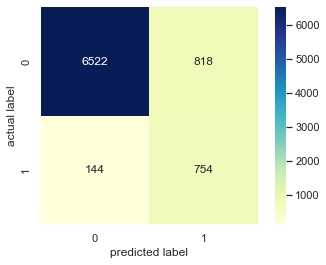

In [14]:
# Plot Confusion Matrix

cm = confusion_matrix(y_holdout,rfcholdoutpreds)
target_labels = np.unique(y_holdout)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Support Vector Machines

A support vector machine uses distance metrics to draw a multidimensional hyperplane that creates a decision boundary which can be used to classify data points. 

<b> Hyperparameters </b>

According to the sci-kit learn documentation, the kernel, degree, and "C" hyperparameters have a big effect on the decision boundary, allowing for increased complexity in its shape. Kernel and degree control the parabola of the decision boundary and its number of curves. C controls the strength of the regularization effect on the boundary. Experimentation with these hyperparameters showed that a kernel setting of "poly", a degree of "5", and a high regularization setting of C, increased the AUC score by up to 2%. Pushing the C hyperparameter above 100 began to reduce the AUC score of the model.


In [15]:
#define, fit, and score 

#create model
svc = SVC(kernel='poly',
          degree=5,
          C=100,
          random_state=125,
          probability=True
         )

#fit model
svc.fit(X_undersample, y_undersample.values.ravel())

#generate accuracy on training
svcpreds = svc.predict(X_undersample)
print('\033[1m'+'Accuracy on training was:'+'\033[0m')
print(accuracy_score(y_undersample,svcpreds))

#generate test preditions
svcholdoutpreds = svc.predict(X_holdout)

#generate AUC
print()
print('\033[1m'+'AUC Was:'+'\033[0m')
y_proba = svc.predict_proba(X_holdout)[:,1]
fpr, tpr, thresholds = roc_curve(y_holdout, y_proba)
print(auc(fpr, tpr))

#generate metrics 
print()
print('\033[1m'+'Comprehensive Metrics for Test:'+'\033[0m')
print()
print(classification_report(y_holdout, svcholdoutpreds,  digits=4))

Accuracy on training was:
0.8710137181542847

AUC Was:
0.9299094111649867

Comprehensive Metrics for Test:

              precision    recall  f1-score   support

           0     0.9757    0.8764    0.9234      7340
           1     0.4486    0.8218    0.5804       898

    accuracy                         0.8705      8238
   macro avg     0.7122    0.8491    0.7519      8238
weighted avg     0.9183    0.8705    0.8860      8238



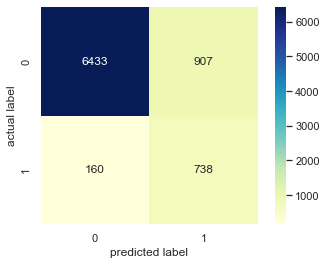

In [16]:
# Plot Confusion Matrix

cm = confusion_matrix(y_holdout,svcholdoutpreds)
target_labels = np.unique(y_holdout)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Neural Network (Multilayer Perception)

Neural networks are a collection of algorithms that use an interconnected matrix of nodes to generate a prediction. Feature values are fed into the top of the network and the values of the nodes that follow generate a prediction for that datapoint at the bottom.

<b> Hyperparameters </b>

Neural networks are sensitive to the number of nodes in each layer. Larger networks usually perform better than smaller ones at the cost of increased training time and computational resources. Several network shapes and sizes were tested and the one that achieved the best performance was selected for the model below. Early stopping is another beneficial hyperparameter for the model. It allows the model to truncate its training loop and return the best weights if its score stops improving during training. These hyperparameters are combined in the neural network below.


Accuracy on training was:
0.8592553001959736

AUC Was:
0.9263990369152159

Comprehensive Metrics for Test:

              precision    recall  f1-score   support

           0       0.97      0.86      0.92      7340
           1       0.42      0.82      0.56       898

    accuracy                           0.86      8238
   macro avg       0.70      0.84      0.74      8238
weighted avg       0.91      0.86      0.88      8238



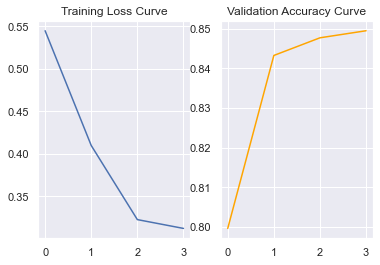

In [17]:

#Define, Train, Test, Score

#Define
mlp = MLPClassifier(hidden_layer_sizes=(1024,512,256,128,64,32,16,8),
                    max_iter=1000, 
                    random_state=125,
                    early_stopping=True,
                   )  

#fit
mlp.fit(X_undersample.values, y_undersample.values.ravel())  

#plot validation and loss
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

#Loss Graph Options
ax1.set_title('Training Loss Curve')
ax1.plot(mlp.loss_curve_)

#Validation Graph options
ax2.set_title('Validation Accuracy Curve')
ax2.plot(mlp.validation_scores_,color='orange')

#generate accuracy on training
mlppreds = mlp.predict(X_undersample)
print('\033[1m''Accuracy on training was:'+'\033[0m')
print(accuracy_score(y_undersample,mlppreds))

#generate AUC
print()
print('\033[1m''AUC Was:'+'\033[0m')
y_proba = mlp.predict_proba(X_holdout)[:,1]
fpr, tpr, thresholds = roc_curve(y_holdout, y_proba)
print(auc(fpr, tpr))

#generate predictions
mlpholdoutpreds = mlp.predict(X_holdout.values)  

#score
print()
print('\033[1m'+'Comprehensive Metrics for Test:'+'\033[0m')
print()
print(classification_report(y_holdout,mlpholdoutpreds))

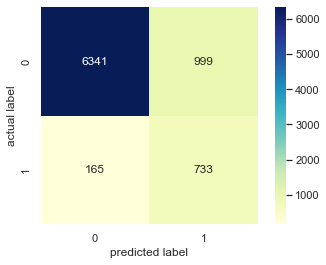

In [18]:
# Plot Confusion Matrix

cm = confusion_matrix(y_holdout,mlpholdoutpreds)
target_labels = np.unique(y_holdout)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Model Comparison

The random forest model had the best prediction performance of all models when judged by AUC. When gauged by raw accuracy, none of these models could outperform the null information rate, however, a model that always predicts no-one will subscribe to a bank account is not very useful to a cold calling campaign. A complete comparison of model metrics is detailed below.

<b> AUC Scores </b>
 - Random Forest: 94.1%
 - Neural Network: 93.3%
 - Support Vector: 92.9%
 
<b> Accuracy on Test </b>
 - Null Accuracy: 89%
 - Random Forest: 88.3%
 - Support Vector: 87%
 - Neural Network: 86%
 
<b> Class 1 Recall on Test </b>
 - Neural Network: 86%
 - Random Forest: 83.9%
 - Support Vector: 82.1%
 
<b> Class 1 Precision on Test </b>
 - Random Forest: 47.9%
 - Support Vector: 44.8%
 - Neural Network: 43%
 
<b> Class 1 F1 on Test </b>
 - Random Forest: 61%
 - Support Vector: 58%
 - Neural Network: 57%


# ROC Curves for Classifiers

Some classifiers return a floating value between 0 and 1 that is used to predict a binary class label. For example, all values below 0.5 might be assigned class 0 and all values above 0.5 class 1. This prediction threshold can be changed to affect the prediction outcome of a model. For any given problem, there is an optimal threshold value that maximizes the true positive predictions made by that model.

A receiver operator characteristic curves display the performance of a model as its decision threshold is changed. A model that guesses at random would have a linear ROC curve cutting straight across the graph. High performing models have steep curves (such as the ones show below) that indicate a sharp tradeoff between false positive and true positive predictions as that threshold is changed.

<b>Ideal Threshold for the Random Forest Classifier = 0.36</b>

An ideal threshold value is represented by the point on the ROC graph closest to the top left corner. This can be computed by taking the geometric mean of each threshold value and selecting the threshold that returned the highest geometric mean. This process resulted in an ideal threshold of 0.36 for the random forest classifier. This operation and the ROC graphs for the classifiers are shown in the code below. <br>

The code used to construct this portion of the notebook was sourced from the sci-kit learn documentation, a tutorial by Jason Brownlee, and a kaggle post by xiziling.


Best Threshold=0.364326 for the Random Forest Classifier


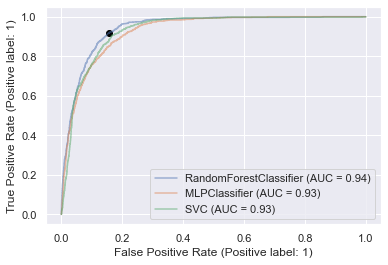

In [19]:
#Plot ROC Curve and best threshold

#https://www.kaggle.com/code/xiziling/roc-curve
#generate false and true positive rates for threshold generation
y_proba = rfc.predict_proba(X_holdout)[:,1]
fpr, tpr, thresholds = roc_curve(y_holdout, y_proba)

#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('\033[1m'+'Best Threshold=%f for the Random Forest Classifier' % (thresholds[ix])+'\033[0m')

#sklearn documentation
# create ROC curves for each Model
ax = plt.gca()

rfc_roc = RocCurveDisplay.from_estimator(rfc, X_holdout, y_holdout, ax=ax, alpha=0.5)
mlp_roc =  RocCurveDisplay.from_estimator(mlp, X_holdout, y_holdout, ax=ax, alpha=0.5)
svc_roc =  RocCurveDisplay.from_estimator(svc, X_holdout, y_holdout, ax=ax, alpha=0.5)

#add threshhold marker
ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='RF Best Threshold')

# Conclusion

The goal of this notebook was to beat the AUC scores achieved by Moro et al. during their original exploration of machine learning in 2014. The authors of that paper were only able to achieve an AUC score of 80% on their highest performing neural network model. The models created with techniques in this notebook outperform that model by at least 10%. The random forest classifier itself achieves an AUC score of 94%, a 14% increase over the accuracy achieved by Moro et al. This increase was a result of advanced data preprocessing and hyperparameter tuning that optimized the model’s ability to predict for a minority class in an imbalanced dataset. These techniques can be employed whenever a model is constructed with imbalanced data to improve its prediction accuracy on the minority class.

# References

This notebook was created using a blend of techniques from Regis's MSDS600, MSDS680, and MSDS650 coursework. In addition to this, the reference literature for sci-kit learn, pandas, and seaborn was consulted to construct the code. Code examples were also taken and reworked from several web sources cited below.

ankthon. (2021). <i> Divide a Pandas DataFrame randomly in a given ratio </i>. Geeks for Geeks. retreived 09/15/2022 from https://www.geeksforgeeks.org/divide-a-pandas-dataframe-randomly-in-a-given-ratio/

Brownlee, Jason. (2020). <i> A Gentle Introduction to Threshold-Moving for Imbalanced Classification </i>. Machine Learning Mastery. Retrieved 09/27/2022 from https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

Javier. (2019). <i> Recall 97% by using undersampling & Neural Network </i>. kaggle.com. retreived 09/15/2022 from https://www.kaggle.com/code/jdelamorena/recall-97-by-using-undersampling-neural-network/notebook

Moro, S. Cortez, P. and Rita, P. (2014) <i>A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems,</i> In press, http://dx.doi.org/10.1016/j.dss.2014.03.001

Pandas Development Team. 2021. <i>Python API reference</i>.from pandas.pydata.org.https://pandas.pydata.org/docs/reference/index.html

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. <i> Journal of Machine Learning Research 12,</i> 2825-2830

Waskom ML (2021). seaborn: statistical data visualization. <i> Journal of Open Source Software 6</i>(60): 3021.a

xiziling. (2016). <i> roc_curve </i>. kaggle retrieved 09/27/2022 from https://www.kaggle.com/code/xiziling/roc-curve/comments